Código adaptado de:

[1] M. Morales. Grokking Deep Reinforcement Learning, Manning Publications Co, 2020.

# Monte-Carlo REINFORCE

## Bibliotecas

In [9]:
! pip install torchinfo

In [10]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from itertools import count
import random
import time
import gymnasium as gym
import gc
import imageio.v2 as iio
from typing import Callable, List
from IPython.display import Image
from torchinfo import summary
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
%matplotlib inline

## Hiperparâmetros

In [11]:
SEED                = 42                # Semente para reprodutibilidade
ENV_ID              = 'CartPole-v1'     # Ambiente Gym utilizado
GAMMA               = 0.99              # Fator de desconto
LEARNING_RATE       = 5e-4              # Taxa de aprendizado
HIDDEN_DIMS         = (128, 64)         # Tamanhos das camadas ocultas da rede neural
MAX_MINUTES         = 20                # Tempo máximo de treinamento (minutos)
MAX_EPISODES        = 10_000            # Número máximo de episódios para treinamento
EVALUATION_EPISODES = 5                 # Episódios de avaliação por ciclo
EVALUATION_GREEDY   = False             # Política estocástica (False) ou gulosa (True) durante a avaliação
DEVICE              = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Usa GPU se disponível
# cria ambiente somente para descobrir dimensões espaço de estados e do espaço de ações
dummy_env = gym.make(ENV_ID)                            # Cria ambiente temporário
nS, nA = dummy_env.observation_space.shape[0], dummy_env.action_space.n  # Dimensão do estado, número de ações
dummy_env.close()                                       # Fecha ambiente temporário

## Rede Neural

In [12]:
# Fully Connected Discrete-Action Policy
class FCDAP(nn.Module):

    # --------------- Construtor: define as camadas da rede --------------- #
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: tuple[int, int] = (32, 32)):
        super().__init__()
        h1, h2 = hidden_dims
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, output_dim)
        )

    # --------------- Formata o estado para tensor e envia para o dispositivo correto --------------- #
    def _format(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32, device=DEVICE)
        else:
            state = state.to(DEVICE)
        if state.dim() == 1:
            state = state.unsqueeze(0)
        return state

    # --------------- Passagem direta pela rede --------------- #
    def forward(self, state):
        return self.net(self._format(state))

    # --------------- Amostra ação, indica exploração, devolve log‑prob e entropia --------------- #
    def full_pass(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logpa = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)
        greedy_action = torch.argmax(logits, dim=-1)
        is_exploratory = (action != greedy_action)
        return action.item(), is_exploratory.item(), logpa, entropy

     # --------------- Seleciona ação estocástica (treino) --------------- #
    def select_action(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.item()

    # --------------- Seleciona ação gulosa (treino ou avaliação) --------------- #
    def select_greedy_action(self, state):
        logits = self.forward(state)
        greedy_action = torch.argmax(logits, dim=-1)
        return greedy_action.item()

## Algoritmo REINFORCE

In [13]:
class REINFORCE:

    # --------------- Construtor: guarda modelo, otimizador e métricas --------------- #
    def __init__(self, policy_model: nn.Module, policy_optimizer: optim.Optimizer):
        self.policy_model           = policy_model
        self.policy_optimizer       = policy_optimizer
        self.performance            = {'mean_return': [],
                                       'std_return': [],
                                       'mean_length': [],
                                       'std_length': [],
                                       'mean_exploration': [],
                                       'std_exploration': []}

    # --------------- Atualiza a rede de política com algoritmo REINFORCE --------------- #
    def optimize_model(self):
        T = len(self.rewards)
        discounts = np.logspace(
            start=0,
            stop=T,
            num=T,
            base=self.gamma,
            endpoint=False
        )
        returns = np.array([np.sum(discounts[:T - t] * self.rewards[t:])for t in range(T)])
        discounts = torch.as_tensor(discounts, dtype=torch.float32, device=DEVICE).unsqueeze(1)
        returns   = torch.as_tensor(returns,   dtype=torch.float32, device=DEVICE).unsqueeze(1)
        self.logpas = torch.cat(self.logpas, dim=0).to(DEVICE)
        policy_loss = -(discounts * returns * self.logpas).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

    # --------------- Executa um passo de interação agente‑ambiente e armazena dados --------------- #
    def interaction_step(self, state, env):
        action, _, logpa, _ = self.policy_model.full_pass(state)
        new_state, reward, terminated, truncated, _ = env.step(action)
        is_terminal = terminated or truncated
        self.logpas.append(logpa)
        self.rewards.append(reward)
        return new_state, is_terminal

    # --------------- Loop de treinamento: coleta episódios, atualiza e avalia --------------- #
    def train(self,
              env: gym.Env,
              seed: int,
              gamma: float,
              max_minutes: float,
              max_episodes: int):

        training_start = time.time()

        # --------------- Guarda configurações locais do agente ---------------
        self.seed   = seed
        self.gamma  = gamma
        self.env_id = env.spec.id if env.spec is not None else str(env)

        # --------------- Define a mesma semente em todas as fontes de aleatoriedade ---------------
        env.reset(seed=self.seed)
        env.action_space.seed(self.seed)
        env.observation_space.seed(self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        bar = tqdm(range(1, max_episodes + 1), desc="Episódios", unit="ep")
        for episode in bar:

            state, _ = env.reset()

            # ---------- coleta de um episódio ----------
            self.logpas = []
            self.rewards = []
            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                if is_terminal:
                    gc.collect()
                    break

            self.optimize_model()

            # ---------- avaliação periódica ----------
            self.evaluate(self.policy_model, env, n_episodes=EVALUATION_EPISODES, greedy=EVALUATION_GREEDY)
            if episode % 10 == 0:
                bar.set_postfix(score=f"{self.performance['mean_return'][-1]:6.1f}")


            # ---------- critérios de parada ----------
            wallclock_elapsed = time.time() - training_start
            if wallclock_elapsed >= max_minutes * 60:
                tqdm.write("Tempo máximo atingido.")
                break
            if episode >= max_episodes:
                tqdm.write("Número máximo de episódios atingido.")
                break

        env.close()

        del env

        return

    # --------------- Avaliação da política sem atualização dos pesos --------------- #
    def evaluate(self,
                eval_policy_model,
                eval_env,
                n_episodes: int = 1,
                greedy: bool = True):

        returns  = []               # retornos acumulados por episódio
        lengths  = []               # passos por episódio
        exploration_ratio = []      # taxas de exploração por episódio

        # ---------- Loop externo: percorre episódios de avaliação ----------
        for _ in range(n_episodes):
            state, _ = eval_env.reset()   # estado inicial
            done = False
            ep_return = 0.0               # retorno acumulada
            ep_length = 0                 # contador de passos
            ep_exploratory = 0            # contador de passos exploratórios

            # ---------- Loop interno: passos dentro do episódio ----------
            for _ in count():
                # Escolha de ação
                if greedy:
                    action = eval_policy_model.select_greedy_action(state)
                    is_exploratory = 0
                else:
                    # action = eval_policy_model.select_action(state)
                    action, is_exploratory, _, _ = eval_policy_model.full_pass(state)

                # ---------- Transição no ambiente ----------
                state, reward, terminated, truncated, _ = eval_env.step(action)
                done = terminated or truncated

                # ---------- Atualiza métricas locais ----------
                ep_return       += reward
                ep_length       += 1
                ep_exploratory  += int(is_exploratory)

                if done:
                    break

            returns.append(ep_return)
            lengths.append(ep_length)
            exploration_ratio.append(ep_exploratory / ep_length if ep_length else 0.0)

        # ---------- Estatísticas agregadas ----------
        for name, data in [("return", returns), ("length", lengths), ("exploration", exploration_ratio)]:
            self.performance[f"mean_{name}"].append(np.mean(data))
            self.performance[f"std_{name}"].append(np.std(data))

        return

## 1. Instancia: ambiente, modelo, otimizador

In [14]:
env       = gym.make(ENV_ID)
model     = FCDAP(env.observation_space.shape[0], env.action_space.n, hidden_dims=HIDDEN_DIMS)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 2. Cria o agente

In [15]:
agent = REINFORCE(policy_model=model,  policy_optimizer=optimizer)
summary(agent.policy_model, input_size=(1, nS), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
FCDAP                                    [1, 4]                    [1, 2]                    --
├─Sequential: 1-1                        [1, 4]                    [1, 2]                    --
│    └─Linear: 2-1                       [1, 4]                    [1, 128]                  640
│    └─ReLU: 2-2                         [1, 128]                  [1, 128]                  --
│    └─Linear: 2-3                       [1, 128]                  [1, 64]                   8,256
│    └─ReLU: 2-4                         [1, 64]                   [1, 64]                   --
│    └─Linear: 2-5                       [1, 64]                   [1, 2]                    130
Total params: 9,026
Trainable params: 9,026
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04

## 3. Treinamento

In [16]:
agent.train(env=env,
            seed=SEED,
            gamma=GAMMA,
            max_minutes=MAX_MINUTES,
            max_episodes=MAX_EPISODES)

Episódios:   0%|          | 0/10000 [00:00<?, ?ep/s]

Tempo máximo atingido.


## Gráficos dos resultados

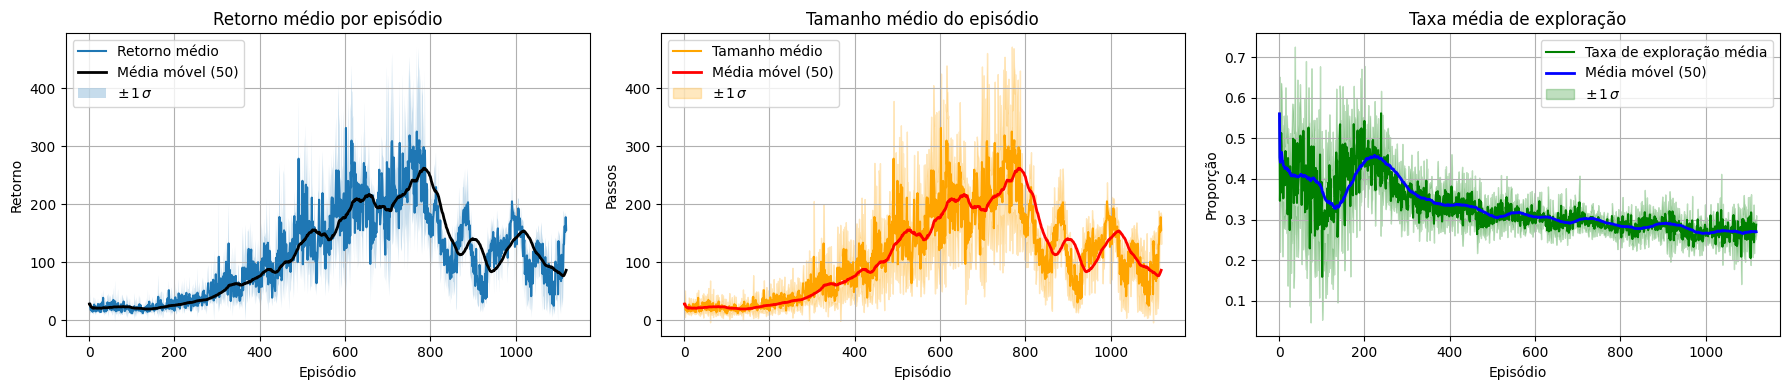

In [17]:
# --------------- Constrói DataFrame com métricas do agente --------------- #
df = pd.DataFrame(agent.performance)
df.insert(0, "episodio", np.arange(1, len(df) + 1))

# --------------- Calcula médias móveis para suavizar as curvas --------------- #
window = 50
for col in ["mean_return", "mean_length", "mean_exploration"]:
    df[f"{col}_ma"] = df[col].rolling(window=window, min_periods=1).mean()

# --------------- Cria figura com três subplots lado a lado --------------- #
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

# --------------- Subplot 1: retorno médio, faixa de desvio e média móvel --------------- #
sns.lineplot(ax=axes[0], data=df, x="episodio", y="mean_return", label="Retorno médio")
axes[0].plot(df["episodio"], df["mean_return_ma"], color="black", linewidth=2, label=f"Média móvel ({window})")
axes[0].fill_between(
    df["episodio"],
    df["mean_return"] - df["std_return"],
    df["mean_return"] + df["std_return"],
    alpha=0.25,
    label=r"$\pm\,1\,\sigma$"
)
axes[0].set_title("Retorno médio por episódio")
axes[0].set_xlabel("Episódio")
axes[0].set_ylabel("Retorno")
axes[0].legend()
axes[0].grid()

# --------------- Subplot 2: comprimento médio, faixa de desvio e média móvel --------------- #
sns.lineplot(ax=axes[1], data=df, x="episodio", y="mean_length", color="orange", label="Tamanho médio")
axes[1].plot(df["episodio"], df["mean_length_ma"], color="red", linewidth=2, label=f"Média móvel ({window})")
axes[1].fill_between(
    df["episodio"],
    df["mean_length"] - df["std_length"],
    df["mean_length"] + df["std_length"],
    alpha=0.25,
    color="orange",
    label=r"$\pm\,1\,\sigma$"
)
axes[1].set_title("Tamanho médio do episódio")
axes[1].set_xlabel("Episódio")
axes[1].set_ylabel("Passos")
axes[1].legend()
axes[1].grid()

# --------------- Subplot 3: taxa de exploração, faixa de desvio e média móvel --------------- #
sns.lineplot(ax=axes[2], data=df, x="episodio", y="mean_exploration", color="green", label="Taxa de exploração média")
axes[2].plot(df["episodio"], df["mean_exploration_ma"], color="blue", linewidth=2, label=f"Média móvel ({window})")
axes[2].fill_between(
    df["episodio"],
    df["mean_exploration"] - df["std_exploration"],
    df["mean_exploration"] + df["std_exploration"],
    alpha=0.25,
    color="green",
    label=r"$\pm\,1\,\sigma$"
)
axes[2].set_title("Taxa média de exploração")
axes[2].set_xlabel("Episódio")
axes[2].set_ylabel("Proporção")
axes[2].legend()
axes[2].grid()

# --------------- Ajusta layout e exibe a figura --------------- #
plt.tight_layout()
plt.savefig(f"{ENV_ID}_desempenho_REINFORCE.png", dpi=300, bbox_inches="tight")
plt.show()


## Simulação com política gulosa

In [18]:
# --------------- Gera um GIF executando a política em vários episódios --------------- #
def gerar_gif_agente(
    policy_fn: Callable[[np.ndarray], int],
    env_id: str,
    path_gif: str,
    n_episodios: int = 5,
    fps: int = 20,
    max_steps: int = 500,
) -> str:

    # --------------- Cria ambiente configurado para renderizar imagens --------------- #
    env = gym.make(env_id, render_mode="rgb_array")

    # --------------- Coleta frames executando a política --------------- #
    frames: List[np.ndarray] = []
    for _ in range(n_episodios):
        obs, _ = env.reset()
        for _ in range(max_steps):
            action = policy_fn(obs)
            obs, _, terminated, truncated, _ = env.step(action)
            frames.append(env.render())
            if terminated or truncated:
                break

    env.close()

    # --------------- Salva a sequência de frames como GIF --------------- #
    iio.mimsave(path_gif, frames, format="GIF", fps=fps)

    return path_gif

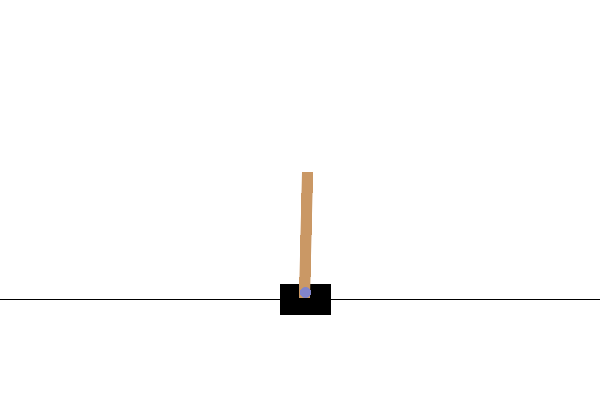

In [19]:
# --------------- Cria GIF da simulação usando a política gulosa e exibe resultado --------------- #
gif_file = gerar_gif_agente(
    policy_fn = agent.policy_model.select_greedy_action,
    env_id    = ENV_ID,
    path_gif  = ENV_ID + "_REINFORCE.gif",
    n_episodios = 5,
    max_steps = 500,
    fps = 30)
Image(filename=gif_file)

# Tarefa

Para o ambiente CartPole-v1, formule e execute 1 experimento em que apenas 1 hiperparâmetro é variado (3 valores) enquanto todos os outros são mantidos constantes. Em seguida compare o desempenho entre as configurações testadas.

O experimento deve:
- Variar 1 hiperparâmetro enquanto todos os demais permanecem fixos. Os hyperparâmetros que podem ser escolhidos para o estudo são:
    - GAMMA
    - LEARNING_RATE
    - HIDDEN_DIMS
- Gerar e analisar gráficos de retorno médio, comprimento médio do episódio e taxa média de exploração;
- Discorrer sobre como a alteração impactou o aprendizado do algoritmo REINFORCE.

##Variando apenas o LEARNING_RATE

Episódios:   0%|          | 0/500 [00:00<?, ?ep/s]

Número máximo de episódios atingido.


Episódios:   0%|          | 0/500 [00:00<?, ?ep/s]

Número máximo de episódios atingido.


Episódios:   0%|          | 0/500 [00:00<?, ?ep/s]

Número máximo de episódios atingido.


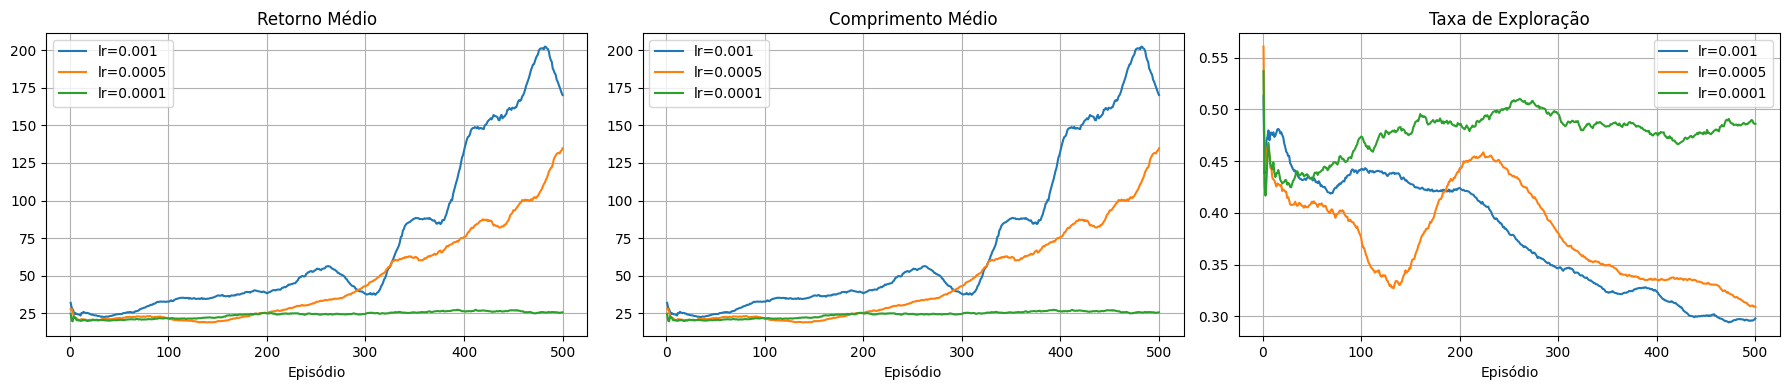

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from itertools import count
import random
import time
import pandas as pd
import gc

# --- Hiperparâmetros fixos ---
GAMMA           = 0.99
HIDDEN_DIMS     = (128, 64)
SEED            = 42
MAX_EPISODES    = 500       # para acelerar o experimento
EVAL_EPISODES   = 5
EVAL_GREEDY     = False
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Valores de LEARNING_RATE a testar ---
LEARNING_RATES = [1e-3, 5e-4, 1e-4]

# (Reutilize aqui sua classe FCDAP e REINFORCE já definidas acima)

results = {}

for lr in LEARNING_RATES:
    # 1) Instancia ambiente, modelo, otimizador e agente
    env       = gym.make('CartPole-v1')
    model     = FCDAP(env.observation_space.shape[0],
                      env.action_space.n,
                      hidden_dims=HIDDEN_DIMS).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    agent     = REINFORCE(policy_model=model,
                          policy_optimizer=optimizer)

    # 2) Treinamento
    agent.train(env=env,
                seed=SEED,
                gamma=GAMMA,
                max_minutes=10,      # alto suficiente para 500 episódios
                max_episodes=MAX_EPISODES)

    # 3) Consolida métricas em DataFrame
    df = pd.DataFrame(agent.performance)
    df.insert(0, "episode", np.arange(1, len(df)+1))
    window = 50
    for col in ["mean_return", "mean_length", "mean_exploration"]:
        df[f"{col}_ma"] = df[col].rolling(window, min_periods=1).mean()

    results[lr] = df
    env.close()

# 4) Plotar comparativo
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
metrics = [("mean_return_ma","Retorno Médio"),
           ("mean_length_ma","Comprimento Médio"),
           ("mean_exploration_ma","Taxa de Exploração")]
for ax, (col, title) in zip(axes, metrics):
    for lr, df in results.items():
        ax.plot(df["episode"], df[col], label=f"lr={lr}")
    ax.set_title(title)
    ax.set_xlabel("Episódio")
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()


In [23]:
for lr, df in results.items():
    print(f"=== LEARNING_RATE = {lr} ===")

    for metric in ["mean_return", "mean_length", "mean_exploration"]:
        data = df[metric]

        print(f"\nMétrica: {metric}")
        print(f"  Média:    {data.mean():.3f}")
        print(f"  Desvio:   {data.std():.3f}")
        print(f"  Mínimo:   {data.min():.3f}")
        print(f"  Mediana:  {data.median():.3f}")
        print(f"  Máximo:   {data.max():.3f}")

    print("\n" + "-"*40 + "\n")


=== LEARNING_RATE = 0.001 ===

Métrica: mean_return
  Média:    77.790
  Desvio:   64.897
  Mínimo:   13.200
  Mediana:  48.000
  Máximo:   328.600

Métrica: mean_length
  Média:    77.790
  Desvio:   64.897
  Mínimo:   13.200
  Mediana:  48.000
  Máximo:   328.600

Métrica: mean_exploration
  Média:    0.370
  Desvio:   0.064
  Mínimo:   0.258
  Mediana:  0.360
  Máximo:   0.564

----------------------------------------

=== LEARNING_RATE = 0.0005 ===

Métrica: mean_return
  Média:    53.054
  Desvio:   41.067
  Mínimo:   11.800
  Mediana:  37.400
  Máximo:   278.400

Métrica: mean_length
  Média:    53.054
  Desvio:   41.067
  Mínimo:   11.800
  Mediana:  37.400
  Máximo:   278.400

Métrica: mean_exploration
  Média:    0.372
  Desvio:   0.063
  Mínimo:   0.158
  Mediana:  0.360
  Máximo:   0.562

----------------------------------------

=== LEARNING_RATE = 0.0001 ===

Métrica: mean_return
  Média:    24.405
  Desvio:   6.054
  Mínimo:   11.800
  Mediana:  23.600
  Máximo:   50.200


# Experimento: Variação de **LEARNING_RATE** no CartPole‑v1

---

## 1. Configuração: `LEARNING_RATE = 0.001`
- **Retorno médio**: 77.8 ± 64.9  
  - Mín: 13.2  
  - Mediana: 48.0  
  - Máx: 328.6  
- **Comprimento médio**: 77.8 ± 64.9  
- **Taxa de exploração**: 0.370 ± 0.064  
  - Mín: 0.258  
  - Mediana: 0.360  
  - Máx: 0.564  

> **Interpretação**  
> - Conforme os gráficos, o **retorno médio e o comprimento médio** sobem rápido, atingem picos elevados antes do final (até ~328), e depois caem um pouco no fim.  
> - A **taxa de exploração** decai de forma contínua, caindo de ~0.51 no início para ~0.26–0.30 ao final, tornando a política cada vez mais determinística.  
> - Atualizações grandes (LR = 0.001) geram aprendizado muito rápido, mas com **alta variância** e exploração prematuramente reduzida.

---

## 2. Configuração: `LEARNING_RATE = 0.0005`
- **Retorno médio**: 53.1 ± 41.1  
  - Mín: 11.8  
  - Mediana: 37.4  
  - Máx: 278.4  
- **Comprimento médio**: 53.1 ± 41.1  
- **Taxa de exploração**: 0.372 ± 0.063  
  - Mín: 0.158  
  - Mediana: 0.360  
  - Máx: 0.562  

> **Interpretação**  
> - Nos gráficos, o **retorno médio** e o **comprimento médio** crescem de forma mais estável ao longo dos 500 episódios, alcançando um máximo (~278) inferior ao de LR=0.001, mas bem acima de LR=0.0001.  
> - A **taxa de exploração** apresenta a **maior variação**: em certos momentos fica até **menor** que com LR=0.001, mas ao final posiciona‑se **acima** de LR=0.001 e **abaixo** de LR=0.0001.  
> - LR intermediário equilibra **velocidade** e **estabilidade**, permitindo exploração controlada e crescimento contínuo do desempenho.

---

## 3. Configuração: `LEARNING_RATE = 0.0001`
- **Retorno médio**: 24.4 ± 6.1  
  - Mín: 11.8  
  - Mediana: 23.6  
  - Máx: 50.2  
- **Comprimento médio**: 24.4 ± 6.1  
- **Taxa de exploração**: 0.479 ± 0.055  
  - Mín: 0.269  
  - Mediana: 0.480  
  - Máx: 0.622  

> **Interpretação**  
> - O **retorno médio** e o **comprimento médio** praticamente **não crescem** ao longo dos episódios, mantendo‑se estagnados em torno de 24.  
> - A **taxa de exploração** **não diminui**, permanecendo alta (entre ~0.27 e ~0.62), pois a política demora a polarizar.  
> - LR muito baixo (0.0001) gera aprendizado **extremamente lento** e **baixa variância**, mas mantém uma exploração elevada.

---

## Conclusão do Experimento

- **Trade‑off Velocidade × Estabilidade**  
  - **LR alto (0.001)** → aprendizado rápido, picos elevados de retorno, mas alta variância e exploração reduzida precocemente.  
  - **LR intermediário (0.0005)** → crescimento contínuo de retorno e comprimento, variação controlada de exploração e menos oscilações extremas.  
  - **LR baixo (0.0001)** → progresso quase nulo em retorno/comprimento, exploração permanece alta e aprendizado muito estável.  
- **Escolha Recomendada**  
  - **LR = 0.0005**: bom compromisso entre rapidez de convergência e estabilidade de política.  
- **Implicações Práticas**  
  - Para **convergência rápida** com risco de oscilação, usar LR = 0.001 mas combinado com técnicas de redução de variância (baseline, entropia).  
  - Para **estabilidade máxima** e persistência exploratória, usar LR = 0.0001, aceitando maior tempo de treinamento.  
  - Para **equilíbrio**, começar com LR = 0.0005 e ajustar conforme o comportamento observado.
